In [1]:
import pandas as pd
import dask as dask
from dask import dataframe as dd
import numpy as np
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask.array as da
import functools
import sys
import ast
from struct import *
import pickle
import glob
import random
import seaborn as sns
import ipywidgets as widgets
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [20]:
cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='7000MiB', #1 GiB = 1,024 MiB
    processes=1)

cluster.scale(10)
#cluster.adapt(minimum=3, maximum=20)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [21]:
client = Client(cluster)

In [22]:
client

Client Scheduler: tcp://169.226.65.49:46047 Dashboard: http://169.226.65.49:37595/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [23]:
files = ['sqlite:///'+f for f in glob.glob("db_files/IPAS_*_flat.sqlite")]
tables = ['aggregates', 'crystals']


In [26]:
%%time

df=[]
for table in tables:
    
    #read tables in parallel on client 
    read_files = [dask.delayed(dd.read_sql_table)(table=table, uri=file, index_col='id') for file in files]
    
    compute_read = client.compute(read_files)
    print('done with compute')
    ddfs = client.gather(compute_read)
    print('done with gather')
    #concatenate all sqlite files vertically (axis=0 default) (same columns)
    gathered_reads = client.scatter(ddfs)
    ddf = client.submit(dd.concat, gathered_reads).result()
    print('done with submit')
    #append combined dask df for each table
    df.append(ddf)


done with compute
done with gather
done with submit
done with compute
done with gather
done with submit
CPU times: user 4.79 s, sys: 347 ms, total: 5.14 s
Wall time: 57.7 s


## Memory info and df stats

In [27]:
df_repart.compute().memory_usage(deep=True).sum()/1E9
#in GB

NameError: name 'df_repart' is not defined

In [ ]:
df[1].info(memory_usage='deep')

In [ ]:
#see partitions
print(df[0].npartitions)
print(df[1].npartitions)

In [ ]:
len(df[0]), len(df[1]) 

In [49]:
df_agg = client.persist(df[0]) 

In [50]:
df_mono = client.persist(df[1]) 

In [15]:
agg_stats = df[0]['agg_phi'].describe().round(2).compute()
agg_stats

count    8232439.00
mean           3.98
std            6.74
min            0.01
25%            0.31
50%            2.76
75%           30.08
max           78.33
Name: agg_phi, dtype: float64

In [16]:
r_stats = df[0]['agg_r'].describe().round(2).compute()
r_stats

count    8232439.00
mean        2454.65
std         5282.27
min            0.46
25%          122.19
50%         1349.11
75%        43820.08
max        67900.97
Name: agg_r, dtype: float64

In [17]:
r_stats = df[1]['r'].describe().round(2).compute()
r_stats

count    8232439.00
mean         214.12
std          304.44
min            1.00
25%           17.50
50%          150.00
75%         1000.00
max         1000.00
Name: r, dtype: float64

In [18]:
phi_stats = df[1]['phi'].describe().round(2).compute()
phi_stats

count    8232439.00
mean          13.01
std           25.22
min            0.01
25%            0.18
50%            5.46
75%          100.00
max          100.00
Name: phi, dtype: float64

In [195]:
#len(df_crys[df_crys.r == 50])
# frequency count of mono r
count = df[1].r.value_counts() 
# Multi-column frequency count 
count = df_repart.groupby(['agg_phi']).count().compute()
print(count)

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 652, in log_errors
    yield
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/scheduler.py", line 3380, in retire_workers
    lock=False,
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/scheduler.py", line 3134, in replicate
    assert count > 0
AssertionError
distributed.core - ERROR - 
Traceback (most recent call last):
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/core.py", line 412, in handle_comm
    result = await result
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/scheduler.py", line 3380, in retire_workers
    lock=False,
  File "/network/rit/lab/sulialab/sha

KeyboardInterrupt: 

## Concat, Repartition, and Clean Up DFs

In [28]:
%time df_concat = dd.concat([df[0], df[1]], axis=1)

CPU times: user 4.16 ms, sys: 5 µs, total: 4.16 ms
Wall time: 7.9 ms


/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/dataframe/multi.py:1055: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


In [29]:
df_concat.agg_r = np.power((np.power(df_concat.a, 2) * df_concat.c), (1./3.))

In [30]:
def query_r_5000(df):
    return df[df.agg_r < 5000]

df_concat = df_concat.map_partitions(query_r_5000)
len(df_concat) #86% of dataset

7353353

In [31]:
df_repart = df_concat.repartition(partition_size="100MB").persist()
df_repart.npartitions

58

In [21]:
res.value_counts()

NameError: name 'res' is not defined

In [33]:
#df_concat._meta.dtypes
#df_concat.divisions
print(df_concat.npartitions)
print(df_concat.memory_usage(deep=True).sum().compute() / 1024**2)  #5.1 GB

200
5103.192663192749


## Test agg agg queries for collection 

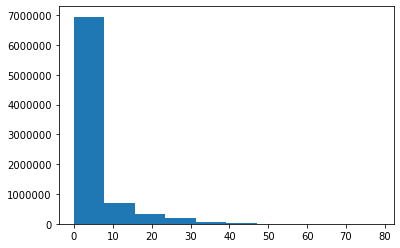

In [193]:
plt.hist(df_repart.agg_phi.compute(), bins =10)
plt.show()

In [32]:
#FLAT
file = open('instance_files/instance_db_aggagg_flat', 'rb')
b1 = pickle.load(file)

#a=z b=y c=x

#dunnavan: a>= b >= c
#in our case z >= y >= x

nclusters = 300
rxs_flat = np.zeros((20,20,nclusters))
rys_flat = np.zeros((20,20,nclusters))
rzs_flat = np.zeros((20,20,nclusters))
phi2Ds_flat = np.zeros((20,20,nclusters))
cplxs_flat = np.zeros((20,20,nclusters))
dds_flat = np.zeros((20,20,nclusters))

counter=0
for phi in range(20):
    for r in range(20):
        rxs_flat[phi, r, :] = np.array(b1[counter][0])[:,0]
        rys_flat[phi, r, :] = np.array(b1[counter][0])[:,1]
        rzs_flat[phi, r, :] = np.array(b1[counter][0])[:,2]
        phi2Ds_flat[phi, r, :] = b1[counter][1]
        cplxs_flat[phi, r, :] = b1[counter][2]
        dds_flat[phi, r, :] = b1[counter][3]
        counter+=1
phiba_flat = rys_flat/rzs_flat
phica_flat = rxs_flat/rzs_flat
np.shape(phica_flat)

(20, 20, 300)

In [59]:
for r in range(19):
    plt.hist(np.mean(cplxs_flat[:,r,:], axis=2), bins =10)


IndexError: tuple index out of range

In [35]:
def query_ncrystals(df_phi, r_bins):
    avg_ncrystals = []
    for r in range(len(r_bins)-1):
        df = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_ncrystals.append(df.r.mean().compute())
    return avg_ncrystals


In [51]:
def avg_cplx(i, r_bins):
    avg_cplx = []
    for r in range(len(r_bins)-1):
        avg_cplx.append(np.mean(cplxs_flat[i,r,:]))
    return avg_cplx


In [52]:
res, phi_bins = pd.qcut(df_repart.agg_phi.compute(), 20, retbins=True)
#print(phi_bins)
phi_bin_labs = []
avg_ncrystals=np.empty((len(phi_bins)-1,len(phi_bins)-1))
avg_cplxs=np.empty((len(phi_bins)-1,len(phi_bins)-1))
all_r_bins = np.empty((len(phi_bins),len(phi_bins)))

for i in range(len(phi_bins)-1):
    print('i = ', i)
    phi_bin_labs.append('[%.3f-%.3f]' %(phi_bins[i],phi_bins[i+1]))
    #return a df that only queries within an aspect ratio bin
    df_phi = df_repart[(df_repart.agg_phi > phi_bins[i]) & (df_repart.agg_phi < phi_bins[i+1])]
    #now break that aspect ratio bin into 20 equal r bins
    res, r_bins = pd.qcut(df_phi.agg_r.compute(), 20, retbins=True)

    all_r_bins[i,:]=r_bins
    #now use those r bins from the output of queried r and phi to find # of monomers per bin
    avg_ncrystals[i,:] = query_ncrystals(df_phi, r_bins)
    avg_cplxs[i,:] = avg_cplx(i, r_bins)
    
    

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19


-229.03165543273707 0.9900147804771723
i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


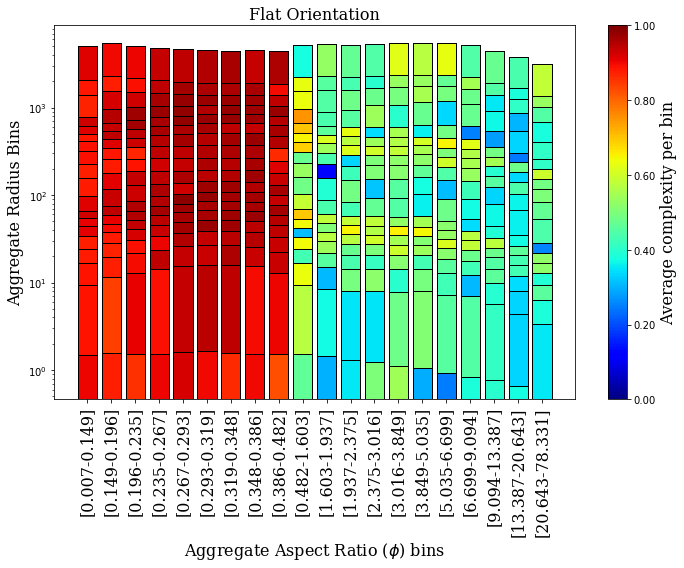

In [58]:
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.cm.jet
vmin=np.amin(avg_cplxs)
vmax=np.amax(avg_cplxs)
print(vmin, vmax) 
#1.3914486210085406 907.974759288473   flat r max min
#1.2451487710219922 640.6597671410091  rand r

#flat
#mono_r = vmin=np.amin(avg_ncrystals), vmax=np.amax(avg_ncrystals)
#norm = matplotlib.colors.LogNorm(vmin=1.2, vmax=900)
#norm = matplotlib.colors.Normalize(vmin=5, vmax=38)

norm = matplotlib.colors.LogNorm(vmin=0.5, vmax=1.0)

for i in range(len(phi_bins)-1): 
    print('i= ', i)
    for r in range(len(r_bins)-2):
        if r != 0:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1], color=cmap(norm(avg_cplxs[i,r])),edgecolor='k')
        else:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(avg_cplxs[i,r])), edgecolor='k')
        
#     for x,y in zip([i]*len(r_bins), r_bins):

#         label = "{:.2f}".format(y)

#         plt.annotate(label, # this is the text
#                      (x,y), # this is the point to label
#                      textcoords="offset points", # how to position the text
#                      xytext=(0,1), # distance from text to points (x,y)
#                      ha='center') # horizontal alignment can be left, right or center

    
plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins",fontsize=16,family='serif')
plt.xlabel("Aggregate Aspect Ratio ($\phi$) bins",fontsize=16,family='serif')  
cb = plt.cm.ScalarMappable(cmap=cmap)
cbar = plt.colorbar(cb,format='%.2f')
#cbar.ax.set_ylabel('Average # of monomers per bin', fontsize=16, family='serif')
cbar.ax.set_ylabel('Average complexity per bin', fontsize=16, family='serif')
#plt.title('Quasi-Horizontal Orientation',fontsize=16, family='serif')
plt.title('Flat Orientation',fontsize=16, family='serif')
plt.tight_layout()
#plt.savefig('bins_rand_meanmono_r_5000rad_logy.pdf')

#sm.set_label('Average # of monomers in the aggregates')
#textstr = '$n$ values per $phi$ :', str(res.value_counts()[0])
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#        vertical alignment='top', bbox=dict(boxstyle='round'))
#17716 values per phi, per r

In [ ]:
# res, phi_bins = pd.qcut(df_repart.agg_phi.compute(), 20, retbins=True)
print(phi_bins)
phi_bin_labs = []
for i in range(len(phi_bins)-1):
    #print('i = ', i)
    if i % 2 == 0:
        phi_bin_labs.append('[%.3f-%.3f]' %(phi_bins[i],phi_bins[i+2]))
    df_phi = df_repart[(df_repart.agg_phi > phi_bins[i]) & (df_repart.agg_phi < phi_bins[i+1])]
    res, r_bins = pd.qcut(df_phi.agg_r.compute(), 20, retbins=True)
    plt.scatter([i]*len(phi_bins), r_bins, marker = "_")
plt.yscale('log')
plt.xticks(np.arange(0,len(phi_bin_labs*2),2), phi_bin_labs, rotation=45)
plt.ylabel("Radius Bin Edges",fontsize=16)
plt.xlabel("Aspect Ratio $\phi$",fontsize=16)  
plt.savefig('bins_random_meanr_log.eps')
#columns tend to aggregate 

In [ ]:
# Create the pandas DataFrame 
data = [{'0':4, '1': 2, '2':3}, {'0': 10, '1': 20, '2': 30}] 
  
# Creates padas DataFrame by passing  
# Lists of dictionaries and row index. 
df_test = pd.DataFrame(data, index =['first', 'second']) 
net.load_df(df_test)
net.widget()

In [66]:
pd_df = df_repart.drop(['points', 'a', 'b', 'c', 'phi2D', 'cplx', 'agg_id', 'phi', 'r'], axis=1).compute()
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8232439 entries, 1 to 44100
Data columns (total 3 columns):
ncrystals    int64
agg_phi      float64
agg_r        float64
dtypes: float64(2), int64(1)
memory usage: 251.2 MB
